In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

plt.style.use('seaborn')
%matplotlib inline

def scaleContinuous(X):
    cont_df = X[(X.isin([0, 1])).all().
                index[(X.isin([0, 1])).all() == False]]
    df = pd.DataFrame(preprocessing.scale(cont_df), columns = cont_df.columns)
    
    bin_cols = (X.isin([0, 1])).all().index[(X.isin([0, 1])).all() == True]
    df = pd.concat([df, pd.DataFrame(columns = bin_cols)])
    df[bin_cols] = X[(X.isin([0, 1])).all().
                     index[(X.isin([0, 1])).all() == True]].values
    return df

data = pd.read_csv(r'Rebound_Features.csv')
drop_cols = []
# drop_cols = [col for col in data.columns if 'VEL' in col]
# drop_cols.extend([col for col in data.columns if 'BOXEDOUT' in col])
drop_cols.append('REBOUNDER')

X = data.drop(set(drop_cols), axis=1)
y = data['REBOUNDER'].astype(int)

t0 = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train2 = scaleContinuous(X_train)
X_test2 = scaleContinuous(X_test)

classifiers = {
    'Logit': LogisticRegression(),
#     'SVM - RBF': SVC(kernel="rbf", C=1, gamma = .001),
#     'SVM - Linear': SVC(kernel='linear', C=1),
    'Neural Net': MLPClassifier(alpha=1, max_iter = 1000, learning_rate_init=.01),
    'KNN': KNN(n_neighbors=5),
    'Gradient Boosted': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0)
}

for key, model in classifiers.items():
    model.fit(X_train2, y_train)
    y_pred = model.predict(X_test2)
    model.fit(X_train, y_train)
    y_pred2 = model.predict(X_test)
    scores = cross_val_score(model, X_train2, y_train, scoring='recall', cv=10)
    print(key)
    print('CV Recall: {}'.format(scores.mean()))
    print(metrics.confusion_matrix(y_test, y_pred))
    print('Scaled Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('Unscaled Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred2)))
    print('\n')

t1 = time.time()
print(t1-t0)

Logit
CV Recall: 0.46556775514848103
[[3347  129]
 [ 420  347]]
Scaled Accuracy: 0.8706104171576715
Unscaled Accuracy: 0.870139052557153


Neural Net
CV Recall: 0.5135936966662873
[[3321  155]
 [ 385  382]]
Scaled Accuracy: 0.8727315578600047
Unscaled Accuracy: 0.8326655668159322


KNN
CV Recall: 0.3385112071908067
[[3245  231]
 [ 491  276]]
Scaled Accuracy: 0.8298373792128211
Unscaled Accuracy: 0.8133396181946736


Gradient Boosted
CV Recall: 0.5173825236090568
[[3283  193]
 [ 377  390]]
Scaled Accuracy: 0.8656610888522271
Unscaled Accuracy: 0.8640113127504124


21.45622754096985


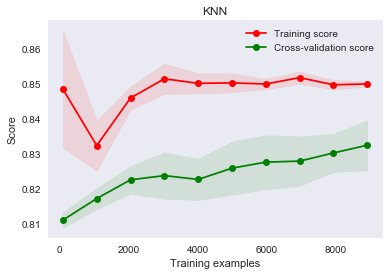

In [29]:
from sklearn.model_selection import learning_curve

model = LogisticRegression()
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

classifiers = {
#     'Logit': LogisticRegression(),
#     'SVM - RBF': SVC(kernel="rbf", C=1, gamma = .001),
#     'SVM - Linear': SVC(kernel='linear', C=1),
#     'Neural Net': MLPClassifier(alpha=1, max_iter = 1000, learning_rate_init=.01),
    'KNN': KNN(n_neighbors=10),
#     'Gradient Boosted': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#                                     max_depth=1, random_state=0)
}

for key, model in classifiers.items():
    plot_learning_curve(model, key, X_train2, y_train, cv=10,
    train_sizes=np.linspace(.01,1.0, 10))
    plt.show()

In [42]:
for n in range(1, 20):
#     model = GradientBoostingClassifier(n_estimators=n, learning_rate=1.0,
#                                         max_depth=1, random_state=0)
    model = MLPClassifier(alpha=1, solver='sgd',max_iter = n, learning_rate_init=.01)
    model.fit(X_train2, y_train)
    y_pred = model.predict(X_test2)
    y_train_pred = model.predict(X_train2)
#     scores = cross_val_score(model, X_train2, y_train, scoring='recall', cv=10)
    print('{} Iterations'.format(n))
#     print('CV Recall: {}'.format(scores.mean()))
    print(model.n_iter_)
    print(metrics.confusion_matrix(y_test, y_pred))
    print('Test Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('Train Accuracy: {}'.format(metrics.accuracy_score(y_train, y_train_pred)))
    print('\n')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1 Iterations
1
[[3436   40]
 [ 660  107]]
Test Accuracy: 0.8350223898185246
Train Accuracy: 0.8278614001414284


2 Iterations
2
[[3397   79]
 [ 590  177]]
Test Accuracy: 0.8423285411265614
Train Accuracy: 0.8432164865137892




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3 Iterations
3
[[3365  111]
 [ 524  243]]
Test Accuracy: 0.8503417393353759
Train Accuracy: 0.8488736235983433


4 Iterations
4
[[3356  120]
 [ 497  270]]
Test Accuracy: 0.8545840207400425
Train Accuracy: 0.8528134154965148




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5 Iterations
5
[[3371  105]
 [ 482  285]]
Test Accuracy: 0.8616544897478199
Train Accuracy: 0.8541266794625719




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6 Iterations
6
[[3345  131]
 [ 459  308]]
Test Accuracy: 0.8609474428470422
Train Accuracy: 0.8580664713607435




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7 Iterations
7
[[3343  133]
 [ 461  306]]
Test Accuracy: 0.8600047136460052
Train Accuracy: 0.8580664713607435




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


8 Iterations
8
[[3337  139]
 [ 449  318]]
Test Accuracy: 0.8614188074475607
Train Accuracy: 0.8607940195979392




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


9 Iterations
9
[[3330  146]
 [ 432  335]]
Test Accuracy: 0.8637756304501532
Train Accuracy: 0.8663501363774119




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


10 Iterations
10
[[3339  137]
 [ 438  329]]
Test Accuracy: 0.864482677350931
Train Accuracy: 0.8616021820385897




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


11 Iterations
11
[[3332  144]
 [ 426  341]]
Test Accuracy: 0.8656610888522271
Train Accuracy: 0.8644307505808667




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


12 Iterations
12
[[3336  140]
 [ 423  344]]
Test Accuracy: 0.867310864954042
Train Accuracy: 0.8661480957672493




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


13 Iterations
13
[[3325  151]
 [ 420  347]]
Test Accuracy: 0.865425406551968
Train Accuracy: 0.8659460551570866




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


14 Iterations
14
[[3320  156]
 [ 402  365]]
Test Accuracy: 0.8684892764553382
Train Accuracy: 0.8693807455298515




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


15 Iterations
15
[[3324  152]
 [ 405  362]]
Test Accuracy: 0.8687249587555974
Train Accuracy: 0.8693807455298515




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


16 Iterations
16
[[3349  127]
 [ 426  341]]
Test Accuracy: 0.8696676879566344
Train Accuracy: 0.8670572785129811




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


17 Iterations
17
[[3321  155]
 [ 421  346]]
Test Accuracy: 0.8642469950506717
Train Accuracy: 0.8691787049196888




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


18 Iterations
18
[[3321  155]
 [ 411  356]]
Test Accuracy: 0.8666038180532643
Train Accuracy: 0.8714011516314779


19 Iterations
19
[[3329  147]
 [ 415  352]]
Test Accuracy: 0.8675465472543012
Train Accuracy: 0.8711991110213153




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
